<a href="https://colab.research.google.com/github/shrevya/ML-portfolio/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multil-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

# 1. Problem
Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

# 2. Data
The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

# 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

# 4.  Features
Some information about the data:

We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
There are 120 breeds of dogs (this means there are 120 different classes).
There are around 10,000+ images in the training set (these images have labels).
There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

In [2]:
# unzip the uploaded data into google drive
#!unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision"

Getting my workspace ready

* Import TensorFlow 2x ✅
* Import TensorFlow Hub ✅
* Making sure GPU is used ✅

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "available(YES!!!)"  if tf.config.list_physical_devices("GPU") else "not available :(")


TF version: 2.13.0
Hub version: 0.14.0
GPU available(YES!!!)


# Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.


In [4]:
# checkout labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv)

                                     id                     breed
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo
2      001cdf01b096e06d78e9e5112d419397                  pekinese
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever
...                                 ...                       ...
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever

[10222 rows x 2 columns]


In [5]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

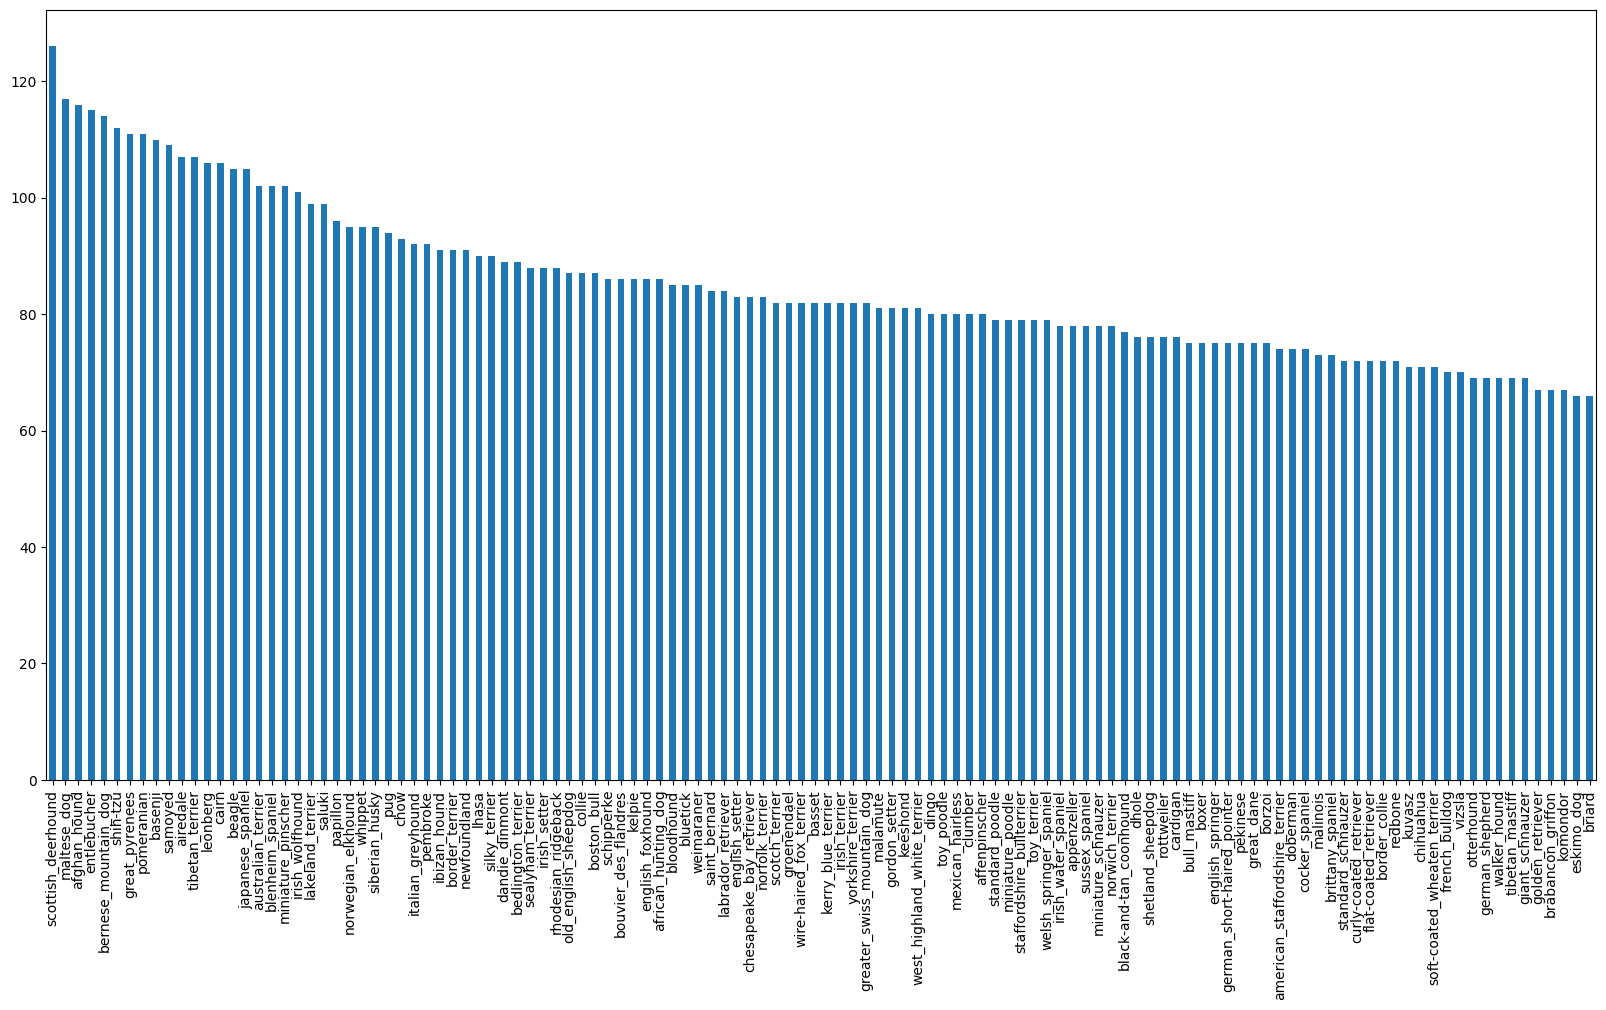

In [6]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize = (20,10));

In [7]:
# what's the median number of images per class?
labels_csv["breed"].value_counts().median()

82.0

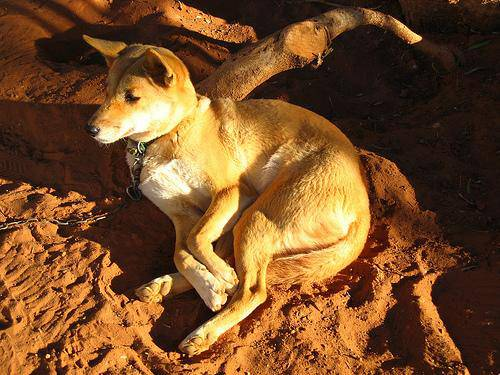

In [8]:
# Let's view an image!
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg"	)

### Getting images and their labels

Let's get a list of our image file pathnames.

In [9]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [10]:
# create filenames from image id's
filenames = ["drive/MyDrive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [11]:
# check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train")) == len(filenames):
  print("Filenames match actual amount of files!! Proceed.")
else:
  print("Filesnames do not match with actual amount of files, check with directory.")

Filenames match actual amount of files!! Proceed.


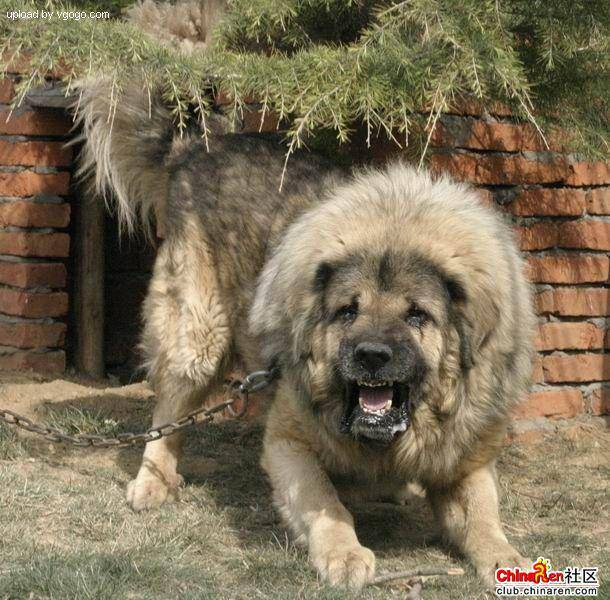

In [12]:
Image(filenames[9000])

In [13]:
labels_csv["breed"] [9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [14]:
import numpy as np
labels = labels_csv["breed"]
np.array(labels)


array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

In [16]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [17]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [18]:
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [19]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [20]:
len(labels)

10222

In [21]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels ]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [22]:
len(boolean_labels)

10222

###**Creating our own validation set**

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.


In [23]:
# Setup X and y variables
X = filenames
y = boolean_labels

In [24]:
len(filenames)

10222

We're going to start off experimenting with ~1000 images and increase as needed.

In [25]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [26]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                    y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [27]:
# Let's have a gaze at the training data
X_train[:5], y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

## **Preprocessing Images (turning images into Tensors)**

To preprocess our images into Tensors we're going to write a function which does a few things:

1.Take an image filepath as input
2.Use TensorFlow to read the file and save it to a variable, image
3.Turn our image (a jpg) into Tensors
4.Normalize our image (convert color channel values from from 0-255 to 0-1).
5.Resize the image to be a shape of (224, 224)
6.Return the modified image



In [28]:
# converting an image to numpy array before preprocessing images
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [29]:
image.max(), image.min()

(255, 0)

In [30]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [31]:
# turning image into tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

We'll create a function to:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, image
3. Turn our image (a jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1).
5. Resize the image to be a shape of (224, 224)
6. Return the modified image

In [32]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image


## **Turning our data into batches**

 we do about 32 (this is the batch size) images at a time



In [33]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [34]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

let's make a function to turn all of our data (X & y) into batches!

In [35]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


In [36]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [37]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## **Visualizing Data Batches**

In [38]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [39]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

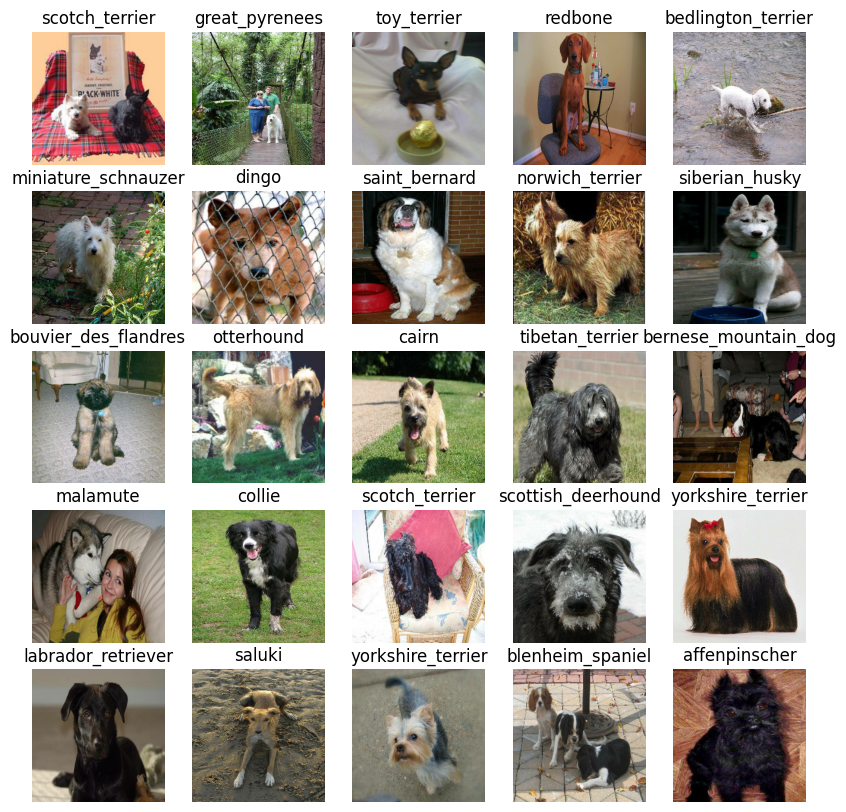

In [40]:
# Visualize training images from the training data batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

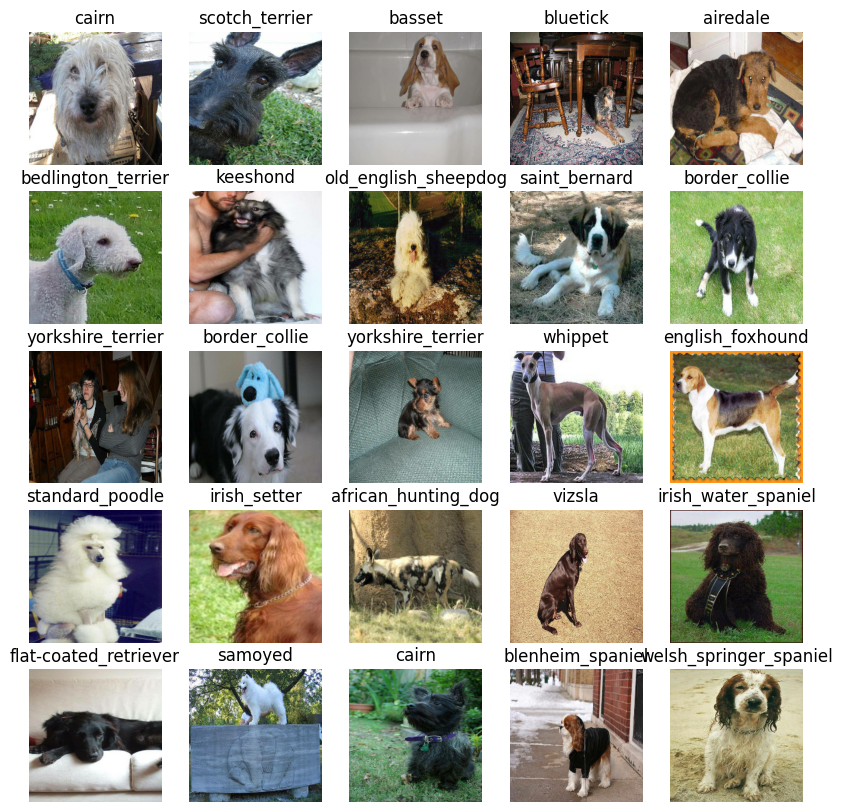

In [41]:
# Visualize validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## **Building a model**


* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [42]:
IMG_SIZE

224

In [43]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


In [44]:
INPUT_SHAPE

[None, 224, 224, 3]

Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:

Takes the input shape, output shape and the model we've chosen as parameters.
Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
Compiles the model (says it should be evaluated and improved).
Builds the model (tells the model the input shape it'll be getting).
Returns the model.
All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [45]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [46]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## **Creating callbacks**
Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

## **TensorBoard Callback**
To setup a TensorBoard callback, we need to do 3 things:

Load the TensorBoard notebook extension ✅
Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function. ✅
Visualize our models training logs with the %tensorboard magic function (we'll do this after model training).

In [47]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [48]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

## **Early Stopping Callback**
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [49]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## **Training a model (on subset of data)**
Our first model is only going to train on 1000 images, to make sure everything is working.

In [50]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}
# Check to make sure we're still running on a GPU
print("GPU", "available (YESSS!!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESSS!!!!!!)


Let's create a function which trains a model.

Create a model using create_model()
Setup a TensorBoard callback using create_tensorboard_callback()
Call the fit() function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use
Return the model

In [51]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [52]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 140s 4s/step - loss: 4.3951 - accuracy: 0.1112 - val_loss: 3.3871 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 3s 105ms/step - loss: 1.5379 - accuracy: 0.7150 - val_loss: 2.1490 - val_accuracy: 0.5050
Epoch 3/100
25/25 [==============================] - 3s 106ms/step - loss: 0.5353 - accuracy: 0.9525 - val_loss: 1.6633 - val_accuracy: 0.6250
Epoch 4/100
25/25 [==============================] - 4s 143ms/step - loss: 0.2401 - accuracy: 0.9912 - val_loss: 1.5015 - val_accuracy: 0.6550
Epoch 5/100
25/25 [==============================] - 3s 109ms/step - loss: 0.1422 - accuracy: 0.9975 - val_loss: 1.4189 - val_accuracy: 0.6850
Epoch 6/100
25/25 [==============================] - 3s 107ms/step - loss: 0.0968 - accuracy: 0.9987 - val_loss: 1.3803 - val_accuracy: 0.6850
Epoch 7/100
25/25 [==============================]

Note to self: Overfitting to begin with is a good thing. It means our model is learning something.

## **Making and evaluating predictions using a trained model**

In [54]:

val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [55]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 84ms/step


array([[9.1563718e-04, 3.1385120e-05, 2.5777446e-04, ..., 1.2390797e-03,
        1.1906519e-05, 4.5337682e-03],
       [2.3227523e-03, 5.0758716e-04, 1.8169371e-02, ..., 4.0157660e-04,
        5.8514178e-03, 2.9291832e-04],
       [2.3952146e-06, 9.4619345e-06, 2.3192366e-05, ..., 9.6163649e-06,
        1.1937970e-04, 5.4883194e-04],
       ...,
       [7.4205886e-06, 1.4440581e-05, 2.0597638e-05, ..., 6.8534659e-06,
        8.3679799e-05, 2.2565475e-05],
       [3.7178542e-03, 2.3712419e-04, 2.8311682e-05, ..., 2.9196229e-04,
        5.9345497e-05, 1.8016450e-02],
       [4.7487745e-04, 5.8452239e-05, 4.6338036e-04, ..., 6.3720914e-03,
        1.8671923e-04, 7.2048075e-05]], dtype=float32)

In [56]:
predictions[0]

array([9.15637182e-04, 3.13851197e-05, 2.57774460e-04, 1.01351397e-05,
       2.70108198e-04, 8.67374547e-05, 5.87505428e-03, 4.86473495e-04,
       2.64862989e-04, 2.86851486e-04, 3.31903691e-04, 1.09728908e-05,
       2.63866765e-04, 2.22262388e-05, 6.48636953e-04, 3.38641717e-03,
       5.65258233e-05, 3.18613738e-01, 1.06639869e-04, 4.42737073e-05,
       1.44852314e-03, 1.44980426e-04, 3.90930063e-06, 2.60521402e-03,
       6.49416370e-06, 1.78102753e-04, 7.95350447e-02, 1.21889381e-04,
       9.70208144e-04, 2.18163725e-04, 4.98828886e-04, 3.77039774e-04,
       5.55471110e-04, 3.08084418e-05, 7.13484260e-05, 1.13898423e-02,
       5.20776521e-05, 3.95607640e-04, 1.55936450e-05, 1.26688101e-04,
       9.17369500e-04, 1.81419473e-05, 3.95706302e-05, 9.43383202e-05,
       3.40871411e-05, 2.59512526e-05, 2.15952332e-05, 6.02738000e-03,
       3.02248591e-05, 1.68941886e-04, 3.72489012e-05, 1.06860374e-04,
       1.11336156e-03, 9.55753203e-05, 3.44722430e-05, 4.98982336e-05,
      

In [57]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.13835322e-05 9.03162581e-05 1.21366165e-05 9.52473965e-06
 1.29870989e-03 7.67602178e-05 5.69266158e-05 1.18297897e-03
 4.92812973e-03 4.86441851e-02 2.41858525e-05 5.86624856e-06
 3.12737277e-04 3.70331109e-03 1.61572360e-04 3.98333883e-03
 1.11006448e-05 1.88569538e-04 1.31070570e-04 2.68744770e-04
 2.99970743e-05 2.32245526e-04 1.10622295e-05 5.41408117e-05
 7.06291711e-03 2.10661037e-05 5.38522872e-05 7.58227543e-05
 2.13768712e-04 3.99824676e-05 1.49687447e-04 3.37007696e-05
 3.59650221e-05 2.82535639e-05 1.60455020e-05 1.54981917e-05
 4.96618450e-05 2.61125533e-04 4.49550826e-05 5.01154065e-01
 1.07056498e-04 1.64756948e-05 1.00013183e-03 1.41284463e-05
 1.20561817e-04 2.55808718e-05 1.88710663e-04 2.93876481e-04
 6.58695717e-06 3.61895567e-04 3.17541308e-05 8.25160751e-05
 1.82587391e-04 9.15583572e-04 1.45270951e-05 2.58167391e-04
 2.55702733e-04 3.13472701e-05 3.20752297e-05 9.07646972e-06
 4.69665465e-05 1.82368633e-04 1.39925987e-05 2.96031831e-05
 9.73101633e-05 4.320110

In [58]:
unique_breeds[113]

'walker_hound'

In [59]:
# Note: Prediction probabilities are also known as confidence levels
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

In [60]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to  get:

Prediction labels
Validation labels (truth labels)
Validation images
Let's make some function to make these all a bit more visaulize.

We'll create a function which:

Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
Convert the prediction probabilities to a predicted label. ✅
Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [61]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

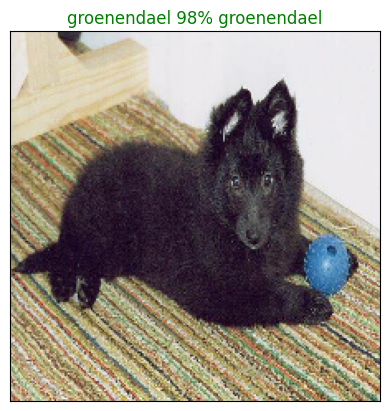

In [62]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)


another function to view our models top 10 predictions.

This function will:

Take an input of prediction probabilities array and a ground truth array and an integer ✅
Find the prediction using get_pred_label() ✅
Find the top 10:
Prediction probabilities indexes ✅
Prediction probabilities values ✅
Prediction labels ✅
Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [63]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

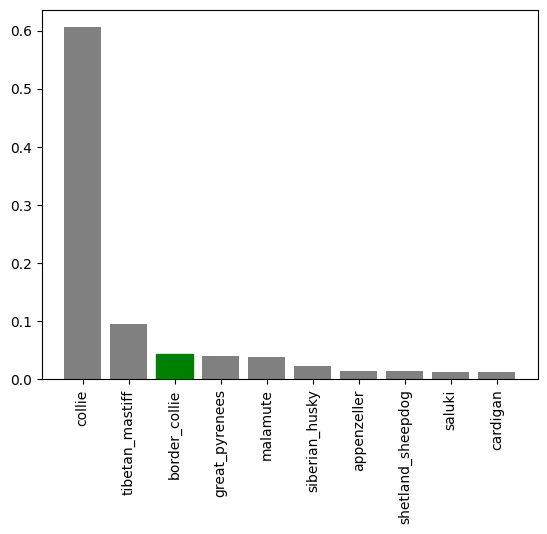

In [64]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

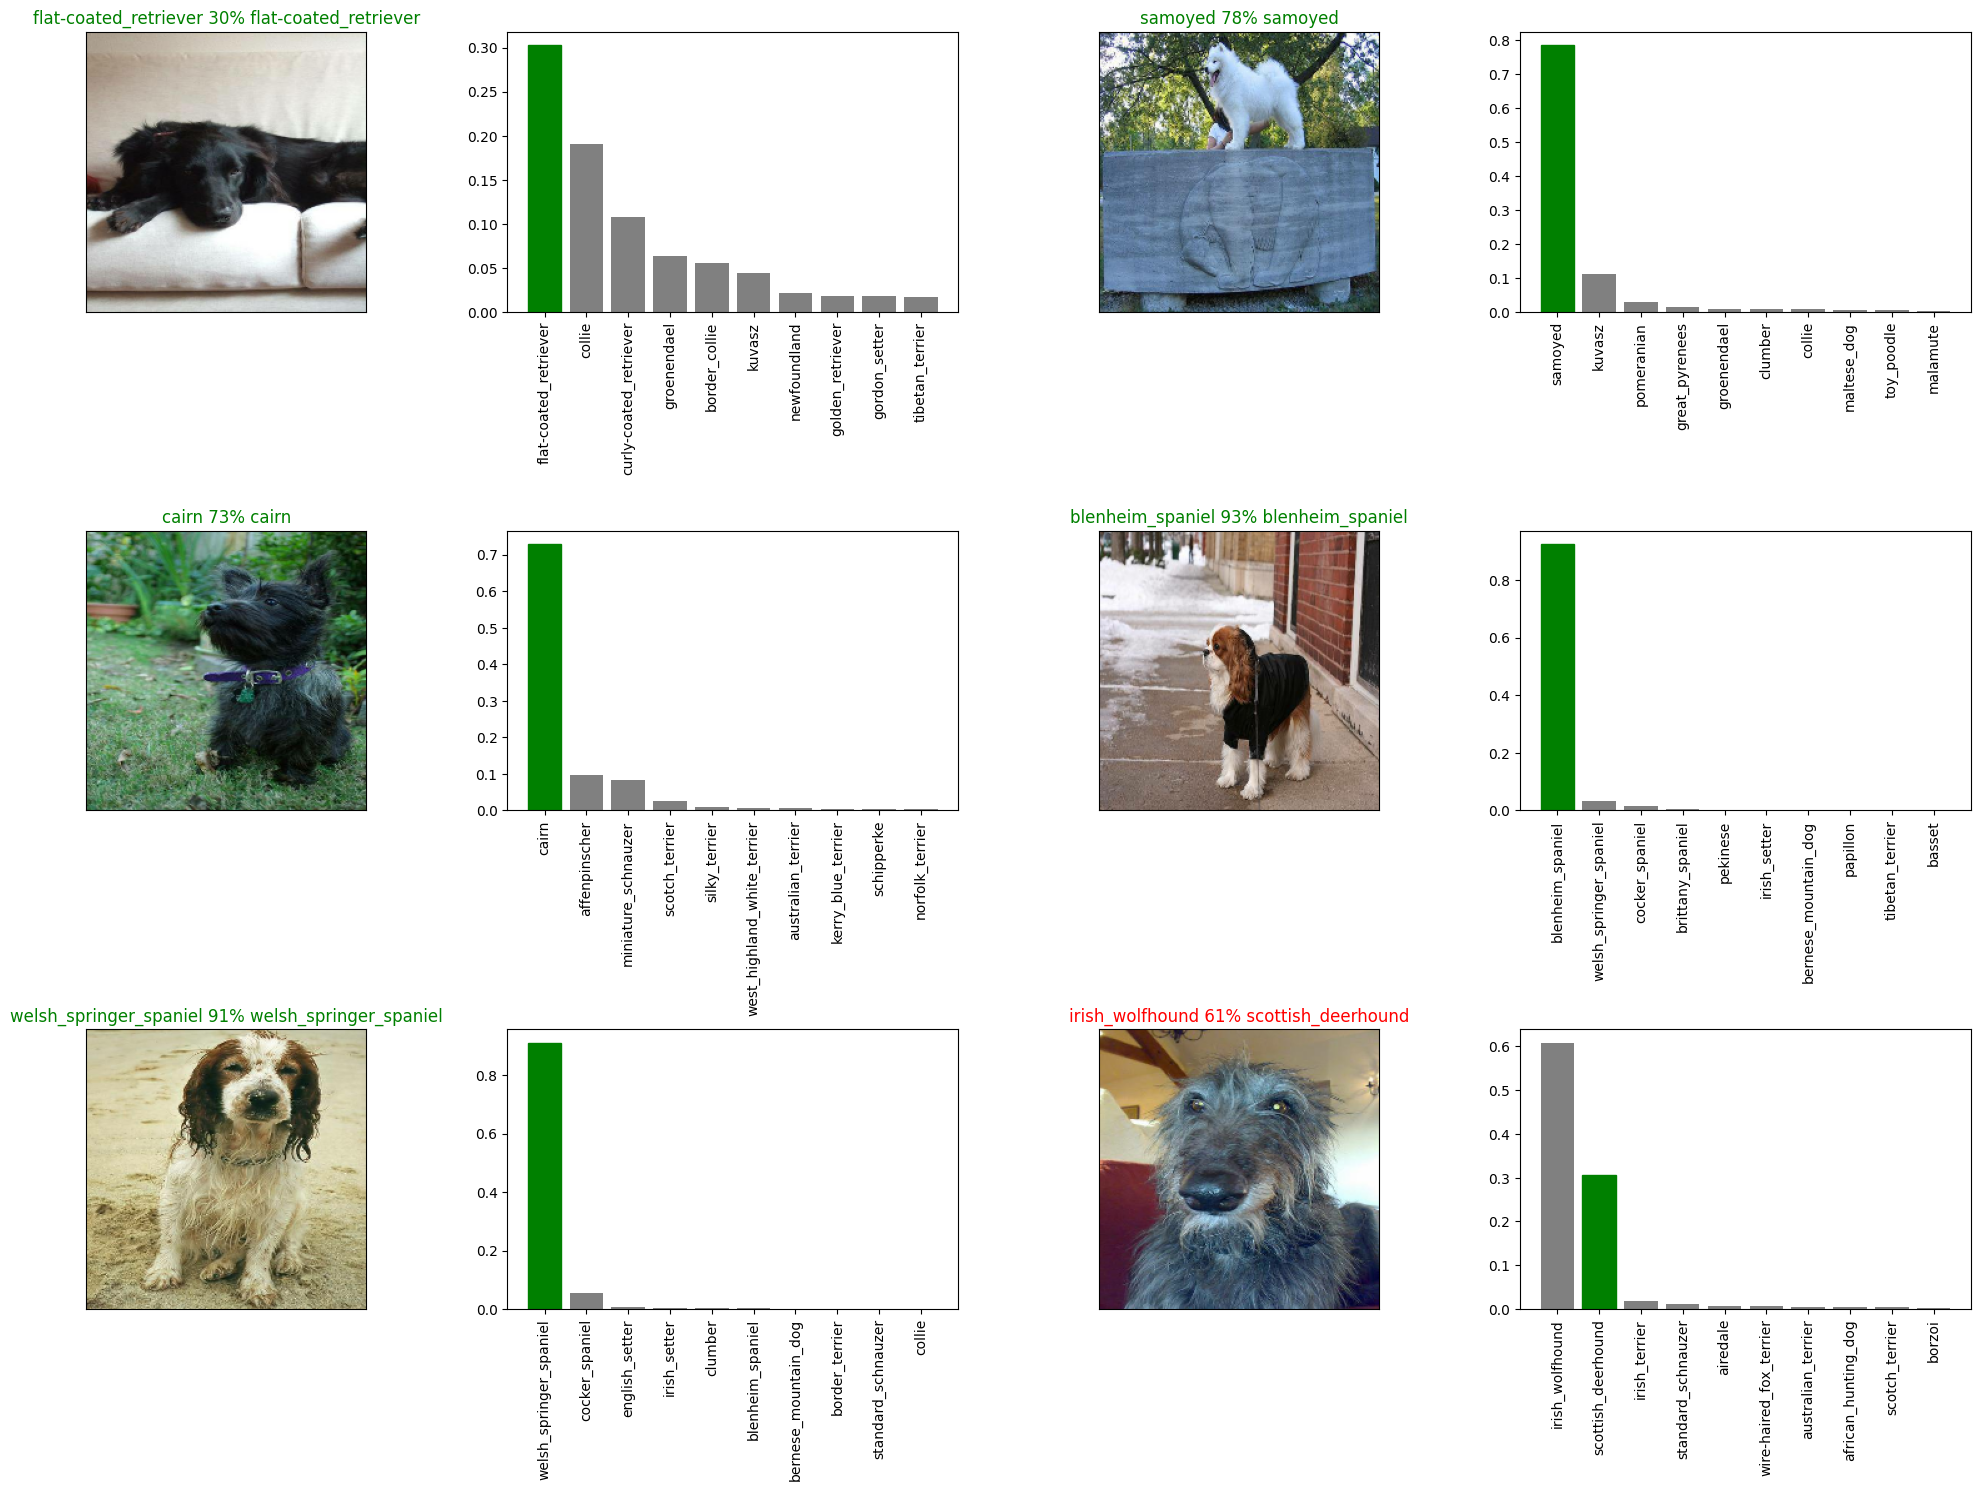

In [65]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## **Saving and reloading a trained model**


In [66]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [67]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [68]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20231008-16151696781716-1000-images-mobilenetv2-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/My Drive/Dog Vision/models/20231008-16151696781716-1000-images-mobilenetv2-Adam.h5'

In [69]:
# Load our model trained on 1000 images

model_1000_images = load_model('drive/MyDrive/Dog Vision/models/20231008-15021696777334-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/MyDrive/Dog Vision/models/20231008-15021696777334-1000-images-mobilenetv2-Adam.h5


In [70]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 74ms/step - loss: 1.2363 - accuracy: 0.7100


[1.2363336086273193, 0.7099999785423279]

In [71]:

# Evaluate the loaded model
model_1000_images.evaluate(val_data)

7/7 [==============================] - 1s 77ms/step - loss: 1.2866 - accuracy: 0.6600


[1.2866425514221191, 0.6600000262260437]

## **Training a big dog model 🐶 (on the full data)**

In [72]:
len(X), len(y)

(10222, 10222)

In [73]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [74]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [75]:
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

In [76]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 34s 92ms/step - loss: 1.3384 - accuracy: 0.6664
Epoch 2/100
320/320 [==============================] - 29s 92ms/step - loss: 0.4027 - accuracy: 0.8840
Epoch 3/100
320/320 [==============================] - 29s 91ms/step - loss: 0.2382 - accuracy: 0.9354
Epoch 4/100
320/320 [==============================] - 29s 91ms/step - loss: 0.1528 - accuracy: 0.9620
Epoch 5/100
320/320 [==============================] - 29s 90ms/step - loss: 0.1064 - accuracy: 0.9794
Epoch 6/100
320/320 [==============================] - 29s 90ms/step - loss: 0.0769 - accuracy: 0.9875
Epoch 7/100
320/320 [==============================] - 29s 91ms/step - loss: 0.0582 - accuracy: 0.9927
Epoch 8/100
320/320 [==============================] - 31s 96ms/step - loss: 0.0479 - accuracy: 0.9937
Epoch 9/100
320/320 [==============================] - 29s 90ms/step - loss: 0.0376 - accuracy: 0.9964
Epoch 10/100
320/320 [==============================] - 29s 91ms/step - l

In [77]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20231008-16271696782452-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20231008-16271696782452-full-image-set-mobilenetv2-Adam.h5'

In [81]:
# Load in the full model
loaded_full_model = load_model('drive/MyDrive/Dog Vision/models/20231008-15021696777334-1000-images-mobilenetv2-Adam.h5')

Loading saved model from: drive/MyDrive/Dog Vision/models/20231008-15021696777334-1000-images-mobilenetv2-Adam.h5


## **Making predictions on the test dataset**

In [82]:
# Load test image filenames
test_path = "drive/My Drive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/test/dd539ec1933bc47bc80b1447a26aef45.jpg',
 'drive/My Drive/Dog Vision/test/dcb9aeaf9f1a5c11e95509376d8788ca.jpg',
 'drive/My Drive/Dog Vision/test/e07106e5301fbce05cade5c94f775a72.jpg',
 'drive/My Drive/Dog Vision/test/e2686707ac5b5f75ce2ccbc906b624d8.jpg',
 'drive/My Drive/Dog Vision/test/e21d378710d164f126e7d0b380dc7a1a.jpg',
 'drive/My Drive/Dog Vision/test/e6999e18a8e98f7fc33cf520d26ec521.jpg',
 'drive/My Drive/Dog Vision/test/dff6d0e5746812e0e5808c0e69a20574.jpg',
 'drive/My Drive/Dog Vision/test/e61cd2626c01dd00117eca55fb099f5d.jpg',
 'drive/My Drive/Dog Vision/test/dff4932a639f0bf9b1e693fff89fc898.jpg',
 'drive/My Drive/Dog Vision/test/e0bf90705facb623a6f36046cc495659.jpg']

In [84]:
len(test_filenames)

10357

In [85]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [86]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 133s 397ms/step


In [87]:
# Check out the test predictions
test_predictions[:10]

array([[1.9447638e-03, 5.7516195e-04, 1.9958614e-04, ..., 2.8243399e-04,
        1.9864769e-04, 4.5273337e-03],
       [3.3653530e-05, 8.2497916e-04, 5.8598862e-06, ..., 2.2719338e-05,
        2.7288756e-01, 1.1200649e-02],
       [8.9260342e-05, 2.2633991e-03, 2.8324637e-05, ..., 2.1673257e-03,
        7.4471217e-01, 6.6663977e-04],
       ...,
       [5.6044279e-05, 2.5792113e-01, 7.6683849e-05, ..., 2.0268906e-03,
        1.5833575e-03, 1.0481949e-03],
       [1.1503037e-01, 8.8436465e-04, 2.6145508e-04, ..., 1.1299352e-04,
        3.0899831e-04, 3.6976257e-04],
       [1.6643351e-02, 1.3865459e-02, 9.6237287e-03, ..., 1.6618118e-01,
        1.4895886e-03, 3.7400014e-04]], dtype=float32)

## **reparing test dataset predictions for Kaggle**
Looking at the Kaggle sample submission, it looks like they want the models output probabilities each for label along with the image ID's.

To get the data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns using the unique_breeds list and the test_predictions list.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [88]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [90]:
# Append test image ID's to predictions DataFrame
test_path = "drive/MyDrive/Dog Vision/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

id affenpinscher afghan_hound  \
0  dd539ec1933bc47bc80b1447a26aef45           NaN          NaN   
1  dcb9aeaf9f1a5c11e95509376d8788ca           NaN          NaN   
2  e07106e5301fbce05cade5c94f775a72           NaN          NaN   
3  e2686707ac5b5f75ce2ccbc906b624d8           NaN          NaN   
4  e21d378710d164f126e7d0b380dc7a1a           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [91]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  dd539ec1933bc47bc80b1447a26aef45       0.001945      0.000575   
1  dcb9aeaf9f1a5c11e95509376d8788ca       0.000034      0.000825   
2  e07106e5301fbce05cade5c94f775a72       0.000089      0.002263   
3  e2686707ac5b5f75ce2ccbc906b624d8       0.001362      0.000021   
4  e21d378710d164f126e7d0b380dc7a1a       0.001024      0.000171   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0             0.000200  0.000029                        0.003577     0.000155   
1             0.000006  0.223098                        0.000033     0.000054   
2             0.000028  0.021954                        0.000113     0.000078   
3             0.000023  0.000134                        0.004094     0.000031   
4             0.000007  0.000054                        0.000495     0.000428   

   australian_terrier   basenji    basset  ...  toy_poodle  toy_terrier  \
0            0.000473  0.000126  0.002873  ...    0.000977     0.000297   
1            0.001424  0.000045  0.000003  ...    0.003057     0.000016   
2            0.002125  0.000940  0.000038  ...    0.000187     0.000859   
3            0.003366  0.012498  0.000043  ...    0.007615     0.000147   
4            0.000751  0.000017  0.000038  ...    0.000377     0.000077   

     vizsla  walker_hound    weimaraner  welsh_springer_spaniel  \
0  0.000397      0.000707  2.908277e-04                0.000180   
1  0.000093      0.000593  7.610149e-06                0.000006   
2  0.000405      0.003060  2.116499e-05                0.000582   
3  0.000005      0.000463  1.784381e-05                0.000033   
4  0.000016      0.002188  7.939475e-07                0.000026   

   west_highland_white_terrier   whippet  wire-haired_fox_terrier  \
0                     0.181251  0.000282                 0.000199   
1                     0.000029  0.000023                 0.272888   
2                     0.002682  0.002167                 0.744712   
3                     0.062986  0.000006                 0.000032   
4                     0.000164  0.000176                 0.000017   

   yorkshire_terrier  
0           0.004527  
1           0.011201  
2           0.000667  
3           0.032751  
4           0.000485  

[5 rows x 121 columns]

In [93]:
preds_df.to_csv("drive/MyDrive/Dog Vision/full_submission_1_mobilienetV2_adam.csv",
                 index=False)

## **Making predictions on custom images**
To make predictions on custom images, we'll:


*   Get the filepaths of our own images.
*   Turn the filepaths into data batches using create_data_batches(). And since our custom images won't have labels, we set the test_data parameter to True.
*   Pass the custom image data batch to our model's predict() method.
*   Convert the prediction output probabilities to predictions labels.
*   Compare the predicted labels to the custom images.












In [110]:
# Get custom image filepaths
custom_path = "drive/MyDrive/Dog Vision/dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [111]:
custom_image_paths

['drive/MyDrive/Dog Vision/dog-photos/dog3.jpg',
 'drive/MyDrive/Dog Vision/dog-photos/dog2.jpg']

In [112]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [113]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 1s 531ms/step


In [114]:
custom_preds.shape

(2, 120)

In [115]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['chihuahua', 'basset']

In [116]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

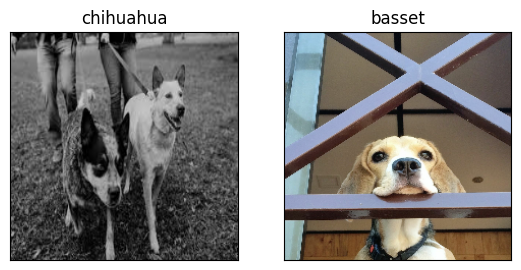

In [117]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)